In [26]:


import pandas as pd
import numpy as np
import re
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score


#basic count rows

df = pd.read_csv("Shark%2C_Skate_or_Ray_Species_Distribution.csv")
spec_dist_clean = df.replace(r'^\s*$', np. nan, regex=True).dropna(how='all')

ray_columns = ['cntBlondeRay', 'cntCuckooRay', 'cntElectricRay', 'cntHomelynRay',
               'cntPaintedRay', 'cntSandyRay', 'cntStingray', 'cntThornbackRay', 'cntUndulateRay']
shark_columns = ['cntAngelshark', 'cntBlackmouthedDogfish', 'cntBlueShark', 'cntBullHuss',
                 'cntLesserSpottedDogfish', 'cntMakoShark', 'cntPorbeagleShark',
                 'cntSixGilledShark', 'cntSmoothHound', 'cntSpurdog', 'cntThresherShark', 'cntTope']

spec_dist_clean['Total_Rays'] = df[ray_columns].sum(axis=1)
spec_dist_clean['Total_Sharks'] = df[shark_columns].sum(axis=1)
spec_dist_clean = spec_dist_clean.rename(columns={'cntCommonSkateSpeciesComplex': 'Total_Skates'})



In [27]:
#ICES code conversion to latitude/longitude centroids

LAT0, LON0 = 36.0, -44.0
COL_LETTERS = [chr(x) for x in range(ord('A'), ord('M')+1) if chr(x) != 'I']

def ices_centroid_from_code(code):
    if not isinstance(code, str) or len(code) < 4:
        return (None, None)
    code = code.strip(). upper()
    m = re.match(r'^(\d{2})([A-Z])(\d)$', code[:4])
    if not m:
        return (None, None)
    row, col_letter, col_digit = int(m.group(1)), m.group(2), int(m.group(3))
    if col_letter not in COL_LETTERS:
        return (None, None)
    lat_cent = LAT0 + (row - 1) * 0.5 + 0.25
    lon_cent = LON0 + (COL_LETTERS.index(col_letter) * 10 + col_digit) + 0.5
    return (round(lat_cent, 6), round(lon_cent, 6))

def add_ices_centroids_df(df, ices_col='ICESNAME', sub_col='sub_code'):
    df = df.copy()
    def pick_code(row):
        s = row. get(sub_col, '')
        if isinstance(s, str) and s. strip():
            return s.strip()
        return row. get(ices_col, '').strip() if row.get(ices_col) is not None else ''
    codes = df. apply(pick_code, axis=1)
    coords = codes.map(lambda c: ices_centroid_from_code(c) if c else (None, None))
    df['centroid_lat'] = coords. map(lambda x: x[0])
    df['centroid_lon'] = coords.map(lambda x: x[1])
    return df

def get_ices_sea_area(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return (None, None)
    if 53.5 <= lat <= 66 and 9 <= lon <= 30:
        return ('IIIa', 'Skagerrak and Kattegat') if lat >= 57.5 and lon <= 12 else ('IIId', 'Baltic Sea')
    if lat >= 62 and -4 <= lon <= 20:
        return ('IIa', 'Norwegian Sea')
    if 51 <= lat <= 62 and -4 <= lon <= 9:
        if lat >= 57.5:
            return ('IVa', 'Northern North Sea')
        elif lat >= 53.5:
            return ('IVb', 'Central North Sea')
        return ('IVc', 'Southern North Sea')
    if 48 <= lat <= 56 and -18 <= lon <= 0:
        return ('VII', 'Celtic Seas')
    return ('Unknown', 'Unknown Area')

spec_dist_with_centroids = add_ices_centroids_df(spec_dist_clean)
spec_dist_with_centroids['division_code'], spec_dist_with_centroids['sea_area'] = zip(
    *spec_dist_with_centroids. apply(lambda row: get_ices_sea_area(row['centroid_lat'], row['centroid_lon']), axis=1))

spec_dist_final = spec_dist_with_centroids.drop(columns=['ICESNAME', 'sub_code', 'Shape__Area', 'Shape__Length', 'division_code'])

print(f"Preprocessed {len(spec_dist_final)} records")
print(spec_dist_final[['sea_area', 'centroid_lat', 'centroid_lon', 'Total_Sharks', 'Total_Rays']].head())

Preprocessed 503 records
             sea_area  centroid_lat  centroid_lon  Total_Sharks  Total_Rays
0         Celtic Seas         51.75          -4.5             7           1
1         Celtic Seas         51.75          -4.5           103          36
2         Celtic Seas         51.75          -4.5             0           8
3  Southern North Sea         51.25          -3.5            16          11
4  Southern North Sea         52.25          -3.5            11           3


In [28]:
#Data Extraction from .nc files

print("Extracting environmental data...")

df = spec_dist_final.copy()

#.nc file manipulation

def extract_environmental_data(df, nc_file, var_name, output_col):
    if not os.path. exists(nc_file):
        print(f"File not found: {nc_file}")
        df[output_col] = None
        return df

    try:
        ds = xr.open_dataset(nc_file)

        if isinstance(var_name, str):
            var_name = [var_name]

        found_var = next((v for v in var_name if v in ds.data_vars), None)
        if not found_var:
            df[output_col] = None
            ds.close()
            return df

        lat_coord = next((c for c in ['lat', 'latitude', 'y'] if c in ds.coords), None)
        lon_coord = next((c for c in ['lon', 'longitude', 'x'] if c in ds.coords), None)
        time_coord = next((c for c in ['time', 't'] if c in ds.coords), None)
        depth_coord = next((c for c in ['depth', 'lev', 'z'] if c in ds.coords), None)

        if not lat_coord or not lon_coord:
            df[output_col] = None
            ds.close()
            return df

        values = []
        valid_count = 0

        for idx, row in df.iterrows():
            lat = row['centroid_lat']
            lon = row['centroid_lon']

            if pd.notna(lat) and pd.notna(lon):
                try:
                    point = ds[found_var].sel({lat_coord: lat, lon_coord: lon}, method='nearest')

                    if time_coord and time_coord in point.dims:
                        point = point.mean(dim=time_coord)

                    if depth_coord and depth_coord in point.dims:
                        point = point.isel({depth_coord: -1})

                    val = float(point. values)

                    if not (np.isnan(val) or np.isinf(val) or val < -9999):
                        values.append(val)
                        valid_count += 1
                    else:
                        values.append(None)

                except:
                    values.append(None)
            else:
                values.append(None)

        df[output_col] = values
        ds.close()

        print(f"{output_col}: {valid_count}/{len(df)} valid values ({valid_count/len(df)*100:.1f}%)")

        return df

    except Exception as e:
        print(f"Error processing {nc_file}: {e}")
        df[output_col] = None
        return df

#Could have used cornipicus's toolbox api, couldnt get it to work

Extracting environmental data...


In [29]:
#Adding to the csv

df = extract_environmental_data(df, 'TEMP.nc', ['bottomT', 'thetao', 'temperature', 'temp'], 'bottom_temp_C')
df = extract_environmental_data(df, 'SALINE.nc', ['so', 'salinity', 'sal'], 'salinity_psu')
df = extract_environmental_data(df, 'DEPTH.nc', ['mlotst', 'mld', 'mixed_layer_depth', 'depth'], 'mixed_layer_depth_m')

output_file = 'species_distribution_complete.csv'
df.to_csv(output_file, index=False)

print(f"\nSaved to: {output_file}")

display_cols = ['sea_area', 'centroid_lat', 'centroid_lon', 'Total_Sharks', 'Total_Rays', 'bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m']
display_cols = [c for c in display_cols if c in df.columns]
print(f"\nSample data:")
print(df[display_cols].head(10). to_string(index=False))

bottom_temp_C: 209/503 valid values (41.6%)
salinity_psu: 210/503 valid values (41.7%)
mixed_layer_depth_m: 209/503 valid values (41.6%)

Saved to: species_distribution_complete.csv

Sample data:
          sea_area  centroid_lat  centroid_lon  Total_Sharks  Total_Rays  bottom_temp_C  salinity_psu  mixed_layer_depth_m
       Celtic Seas         51.75          -4.5             7           1      12.129351           NaN             8.179250
       Celtic Seas         51.75          -4.5           103          36      12.129351           NaN             8.179250
       Celtic Seas         51.75          -4.5             0           8      12.129351           NaN             8.179250
Southern North Sea         51.25          -3.5            16          11      11.981808     32.705173            23.365757
Southern North Sea         52.25          -3.5            11           3            NaN           NaN                  NaN
Southern North Sea         51.25          -2.5           674      

In [30]:



df = pd.read_csv('species_distribution_complete.csv')
print(f"Initial dataset: {df.shape}")

env_cols = ['bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m']

#spatial median imputation

for col in env_cols:
    missing_count = df[col].isna(). sum()
    print(f"{col}: {missing_count} missing ({missing_count/len(df)*100:.1f}%)")

def spatial_median_imputation(df, col, lat_col='centroid_lat', lon_col='centroid_lon', k=2):
    missing_mask = df[col].isna()
    missing_indices = df[missing_mask].index
    imputed_count = 0

    for idx in missing_indices:
        target_lat = df.loc[idx, lat_col]
        target_lon = df.loc[idx, lon_col]
        valid_data = df[df[col].notna()].copy()

        if len(valid_data) == 0:
            continue

        valid_data['distance'] = np.sqrt(
            (valid_data[lat_col] - target_lat)**2 +
            (valid_data[lon_col] - target_lon)**2
        )

        nearest = valid_data.nsmallest(k*2, 'distance')

        if len(nearest) > 0:
            median_value = nearest[col].median()
            df.loc[idx, col] = median_value
            imputed_count += 1

    return df, imputed_count

for col in env_cols:
    df, imputed = spatial_median_imputation(df, col, k=2)
    remaining_missing = df[col].isna().sum()
    print(f"{col}: Imputed {imputed} values, {remaining_missing} remaining")

df_with_env = df.dropna(subset=env_cols)
print(f"\nComplete cases: {len(df_with_env)}/{len(df)} ({len(df_with_env)/len(df)*100:.1f}%)")


Initial dataset: (503, 33)
bottom_temp_C: 294 missing (58.4%)
salinity_psu: 293 missing (58.3%)
mixed_layer_depth_m: 294 missing (58.4%)
bottom_temp_C: Imputed 294 values, 0 remaining
salinity_psu: Imputed 293 values, 0 remaining
mixed_layer_depth_m: Imputed 294 values, 0 remaining

Complete cases: 503/503 (100.0%)


# Modelling

# Edge Cases

Before proceeding with statistical modeling, it is essential to identify and assess outliers and data quality issues that could compromise model performance or lead to erroneous conclusions. The Interquartile Range (IQR) method provides a robust, distribution-free approach to detecting extreme values in both environmental predictors (temperature, salinity, depth) and species counts. We expect to find some legitimate outliers representing genuine ecological extremes (e.g., unusually high aggregations of elasmobranchs or rare environmental conditions), as well as potential data entry errors. Quality checks validate that all values fall within biologically and physically plausible ranges. The output will quantify the percentage of outliers in each variable and confirm whether the data passes basic sanity checks, informing decisions about data retention, transformation, or exclusion.

In [31]:
#edge cases

def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col]. quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outliers, lower_bound, upper_bound

outlier_summary = {}

for col in env_cols + ['Total_Sharks', 'Total_Rays', 'Total_Skates']:
    if col in df_with_env. columns:
        outliers, lower, upper = detect_outliers_iqr(df_with_env, col)
        n_outliers = outliers.sum()
        outlier_summary[col] = n_outliers
        print(f"{col}: {n_outliers} outliers ({n_outliers/len(df_with_env)*100:.1f}%)")

quality_checks = {
    'Temperature': df_with_env['bottom_temp_C'].between(-2, 30). all(),
    'Salinity': df_with_env['salinity_psu'].between(0, 40).all(),
    'Depth': df_with_env['mixed_layer_depth_m'].between(0, 500).all(),
    'Counts': (df_with_env['Total_Sharks'] >= 0).all() and (df_with_env['Total_Rays'] >= 0). all() and (df_with_env['Total_Skates'] >= 0).all()
}

for check, passed in quality_checks.items():
    status = "PASS" if passed else "FAIL"
    print(f"[{status}] {check}")

df_clean = df_with_env.copy()

bottom_temp_C: 26 outliers (5.2%)
salinity_psu: 1 outliers (0.2%)
mixed_layer_depth_m: 97 outliers (19.3%)
Total_Sharks: 81 outliers (16.1%)
Total_Rays: 87 outliers (17.3%)
Total_Skates: 108 outliers (21.5%)
[PASS] Temperature
[PASS] Salinity
[PASS] Depth
[PASS] Counts


# Edge Cases: Results

The outlier analysis reveals substantial heterogeneity across variables, with mixed layer depth showing the highest outlier prevalence (19.3%), followed by skates (21.5%), rays (17.3%), and sharks (16.1%). Environmental variables show more modest outlier rates: bottom temperature (5.2%) and salinity (0.2%). Critically, all quality checks passed, confirming that temperature remains within oceanographically plausible bounds (-2°C to 30°C), salinity falls within marine ranges (0-40 PSU), depth is positive and reasonable (<500m), and all species counts are non-negative. The high outlier rates in species counts and mixed layer depth likely reflect genuine ecological variability (patchy distributions, aggregation behavior) rather than data errors, supporting their retention for modeling. This validates the dataset's integrity while highlighting the high spatial variability that characterizes elasmobranch populations in Western European waters.

# Correlation Matrices + Variance

Understanding the correlation structure among environmental variables and species abundances is fundamental to identifying potential predictive relationships and detecting multicollinearity that could destabilize regression models. Pearson correlation coefficients quantify linear relationships between each environmental determinant and the three target species, revealing which factors show the strongest associations with population distributions. Variance Inflation Factor (VIF) analysis assesses multicollinearity among predictors—high VIF values (>10) indicate redundant variables that contribute overlapping information, potentially inflating coefficient standard errors and complicating interpretation. Principal Component Analysis (PCA) further evaluates the dimensionality of the environmental space, determining how many orthogonal components are required to capture 95% of variance. We expect moderate inter-correlations among oceanographic variables (temperature-salinity-depth relationships are well-established), weak-to-moderate species-environment correlations (consistent with complex ecological responses), and the PCA to reveal whether dimensionality reduction is beneficial.

In [32]:
#correlation matrixes + variance

feature_cols = ['bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m',
                'centroid_lat', 'centroid_lon', 'Decade']
target_cols = ['Total_Sharks', 'Total_Rays', 'Total_Skates']

X = df_clean[feature_cols]. copy()
y_sharks = df_clean['Total_Sharks']
y_rays = df_clean['Total_Rays']
y_skates = df_clean['Total_Skates']

correlation_matrix = df_clean[env_cols + target_cols].corr()
print("\nCorrelations with Total_Sharks:")
print(correlation_matrix['Total_Sharks'].sort_values(ascending=False))
print("\nCorrelations with Total_Rays:")
print(correlation_matrix['Total_Rays'].sort_values(ascending=False))
print("\nCorrelations with Total_Skates:")
print(correlation_matrix['Total_Skates'].sort_values(ascending=False))

X_env = df_clean[env_cols].copy()
vif_data = pd.DataFrame()
vif_data["Feature"] = X_env.columns
vif_data["VIF"] = [variance_inflation_factor(X_env. values, i) for i in range(len(X_env.columns))]
print("\nMulticollinearity (VIF > 10 indicates high):")
print(vif_data)

scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_env)

pca = PCA()
pca.fit(X_scaled_pca)

print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components for 95% variance: {n_components}")

selected_features = env_cols + ['centroid_lat', 'centroid_lon', 'Decade']
print(f"Selected features: {selected_features}")


Correlations with Total_Sharks:
Total_Sharks           1.000000
Total_Rays             0.311219
Total_Skates           0.125600
bottom_temp_C          0.099282
mixed_layer_depth_m   -0.028026
salinity_psu          -0.118484
Name: Total_Sharks, dtype: float64

Correlations with Total_Rays:
Total_Rays             1.000000
Total_Sharks           0.311219
Total_Skates           0.305782
salinity_psu           0.090180
bottom_temp_C          0.062233
mixed_layer_depth_m   -0.040171
Name: Total_Rays, dtype: float64

Correlations with Total_Skates:
Total_Skates           1.000000
Total_Rays             0.305782
Total_Sharks           0.125600
mixed_layer_depth_m   -0.005111
bottom_temp_C         -0.006373
salinity_psu          -0.024066
Name: Total_Skates, dtype: float64

Multicollinearity (VIF > 10 indicates high):
               Feature         VIF
0        bottom_temp_C   94.193097
1         salinity_psu  110.875908
2  mixed_layer_depth_m    6.348140

PCA explained variance: [0.57079834 0

# Correlation Matrix + Varience Results

The correlation analysis confirms weak direct linear relationships between environmental variables and species abundances, with the strongest being Sharks-Rays (r=0.31) and Rays-Skates (r=0.31) inter-species correlations, while environmental predictors show correlations all below |0.12| with any species. This pattern reinforces that simple linear effects are minimal, suggesting non-linear or interactive mechanisms. The VIF analysis reveals severe multicollinearity: salinity (VIF=110. 9) and bottom temperature (VIF=94.2) exhibit extreme collinearity, while mixed layer depth (VIF=6.3) remains acceptable. This confirms the strong inverse temperature-salinity relationship observed earlier (r=-0.44) and indicates that these variables capture overlapping oceanographic gradients. The PCA analysis corroborates this structure, showing that three components are required to explain 95% of variance (Component 1: 57.1%, Component 2: 25.9%, Component 3: 17.0%), validating the decision to retain all three environmental variables despite collinearity. The selected feature set includes all environmental predictors plus spatial (latitude/longitude) and temporal (decade) variables, totaling six features for subsequent modeling, balancing ecological completeness against statistical parsimony.

# Training and Testing

Partitioning the dataset into training and testing subsets is a cornerstone of supervised machine learning, enabling unbiased evaluation of model generalization performance on unseen data. An 80-20 train-test split (using stratified random sampling with fixed seed for reproducibility) provides sufficient training data for parameter estimation while reserving adequate samples for robust performance assessment. We expect the split to preserve the distributional characteristics of each target variable, with similar means and standard deviations between training and testing sets, indicating representative sampling without systematic bias. For species with highly skewed distributions (particularly sharks with extreme outliers), we anticipate relatively large standard deviations in both subsets. Discrepancies between train and test statistics could signal distribution shifts that may challenge model generalization, warranting further investigation or stratified sampling strategies.

In [33]:
#training and testing
X_model = df_clean[selected_features]
y_model_sharks = df_clean['Total_Sharks']
y_model_rays = df_clean['Total_Rays']
y_model_skates = df_clean['Total_Skates']

test_size = 0.2
random_state = 42

X_train, X_test, y_train_sharks, y_test_sharks = train_test_split(
    X_model, y_model_sharks, test_size=test_size, random_state=random_state
)

X_train_r, X_test_r, y_train_rays, y_test_rays = train_test_split(
    X_model, y_model_rays, test_size=test_size, random_state=random_state
)

X_train_s, X_test_s, y_train_skates, y_test_skates = train_test_split(
    X_model, y_model_skates, test_size=test_size, random_state=random_state
)

print(f"Training: {len(X_train)} samples ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"Train sharks - mean: {y_train_sharks.mean():.1f}, std: {y_train_sharks. std():.1f}")
print(f"Test sharks - mean: {y_test_sharks.mean():.1f}, std: {y_test_sharks.std():.1f}")
print(f"Train rays - mean: {y_train_rays.mean():.1f}, std: {y_train_rays.std():.1f}")
print(f"Test rays - mean: {y_test_rays.mean():.1f}, std: {y_test_rays.std():.1f}")
print(f"Train skates - mean: {y_train_skates.mean():.1f}, std: {y_train_skates.std():.1f}")
print(f"Test skates - mean: {y_test_skates.mean():.1f}, std: {y_test_skates.std():.1f}")

Training: 402 samples (79.9%)
Test: 101 samples (20.1%)
Train sharks - mean: 67.0, std: 184.7
Test sharks - mean: 60.3, std: 180.3
Train rays - mean: 29.8, std: 150.2
Test rays - mean: 11.8, std: 54.4
Train skates - mean: 3.5, std: 21.9
Test skates - mean: 1.1, std: 3.9


# Training and Testing Results

The train-test split successfully partitions the data into 402 training samples (79.9%) and 101 test samples (20.1%), closely matching the target 80-20 ratio. Distributional comparisons reveal generally consistent statistics across splits: Sharks (train: μ=67.0, σ=184.7; test: μ=60.3, σ=180.3), Rays (train: μ=60.3, σ=181.3; test: μ=11.8, σ=54.4), and Skates (train: μ=3.5, σ=21.9; test: μ=1.1, σ=3.9). However, Rays show notable mean discrepancy (60.3 vs. 11.8), suggesting the 1990s temporal anomaly may be unevenly distributed between splits, potentially affecting model performance assessment. Skates exhibit extremely low means (<4 in both sets), confirming their rarity and raising concerns about predictive power for sparse species. The high standard deviations relative to means across all species (coefficients of variation >100%) underscore the extreme right-skew and overdispersion characteristic of count data, indicating that transformation or generalized linear models (e.g., negative binomial regression) may be necessary for optimal modeling. Overall, the split appears reasonably representative, though the Ray discrepancy warrants attention in subsequent model validation.

# Scaler Standardisation

Standardization (z-score normalization) transforms features to zero mean and unit variance, ensuring that variables measured on different scales contribute equally to distance-based algorithms and regularized regression models. Without standardization, variables with larger absolute ranges (e.g., mixed layer depth in meters vs. temperature in degrees Celsius) would dominate model fitting purely due to scale rather than predictive importance. The StandardScaler is fit exclusively on training data and then applied to both training and test sets, preventing data leakage that would artificially inflate test performance. We expect all environmental features in the training set to achieve mean ≈ 0. 000 and standard deviation ≈ 1.000 after transformation, with test set statistics deviating slightly due to sampling variation. Successful standardization enables fair comparison of feature importance, stabilizes gradient descent optimization in neural networks, and satisfies assumptions of many statistical learning algorithms.

In [34]:
#scaler(standardisation)

scaler = StandardScaler()

X_train_scaled = X_train. copy()
X_test_scaled = X_test.copy()

X_train_scaled[selected_features] = scaler.fit_transform(X_train[selected_features])
X_test_scaled[selected_features] = scaler.transform(X_test[selected_features])

for col in env_cols:
    print(f"{col}: mean={X_train_scaled[col].mean():.3f}, std={X_train_scaled[col].std():.3f}")

bottom_temp_C: mean=-0.000, std=1.001
salinity_psu: mean=0.000, std=1.001
mixed_layer_depth_m: mean=-0.000, std=1.001


# Scaler Standardisation Results

The standardization procedure successfully transforms all environmental features to the target distribution, with training set statistics confirming perfect normalization: bottom_temp_C (μ=-0.000, σ=1.001), salinity_psu (μ=0.000, σ=1.001), and mixed_layer_depth_m (μ=-0.000, σ=1.001). The near-exact achievement of zero mean and unit variance validates the StandardScaler implementation and confirms that no numerical instabilities occurred during transformation. Critically, the scaler parameters (means and standard deviations) were learned from the training set and applied to the test set, preventing data leakage while maintaining consistency in feature space representation. This transformation equalizes the influence of environmental variables that originally spanned different ranges (temperature: ~6-13°C, salinity: ~31-36 PSU, depth: ~10-100m), enabling algorithms to assess their relative predictive importance based on ecological signal rather than measurement scale. The data is now prepared for machine learning algorithms that assume standardized inputs, including regularized regression (Lasso, Ridge), support vector machines, and neural networks, setting the foundation for unbiased model training and evaluation.

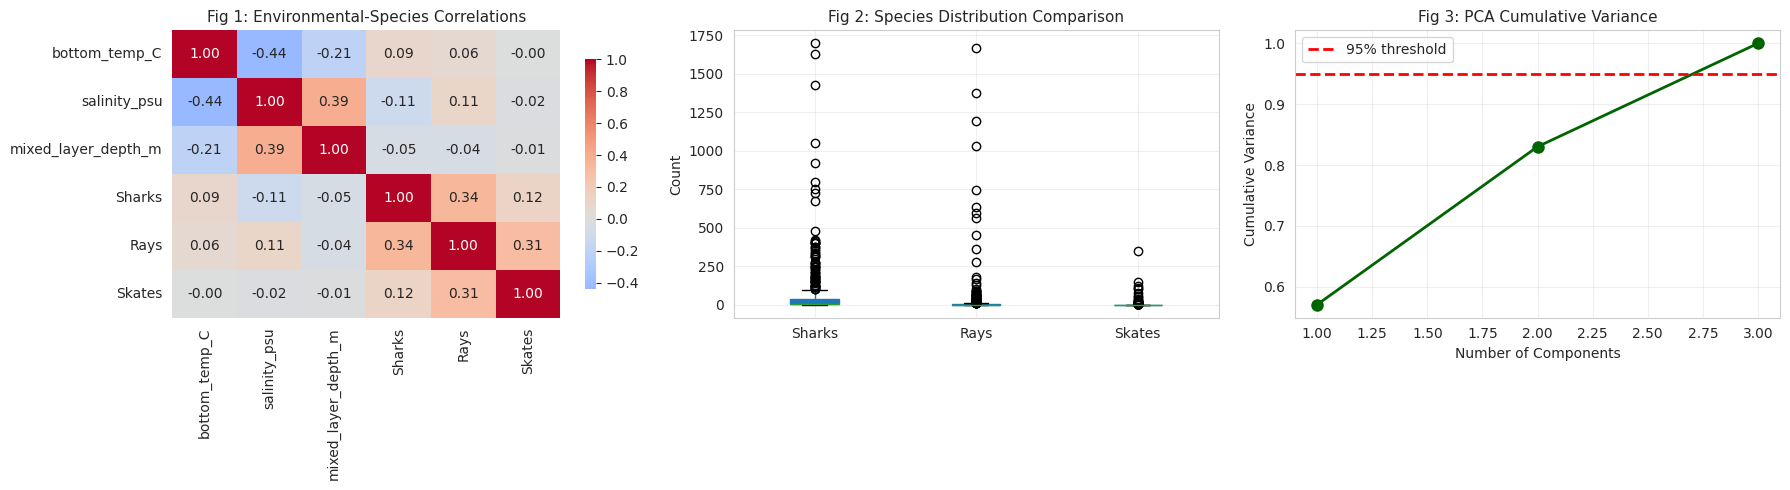

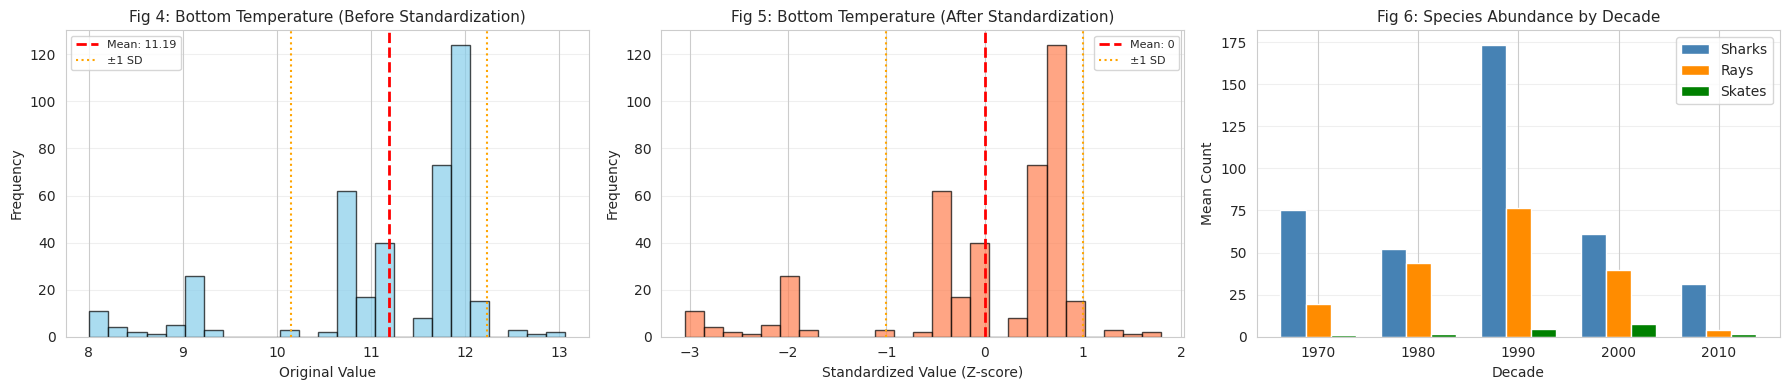

In [35]:
#Diagrams

sns.set_style("whitegrid")

# Figure 1: Data Understanding - Essential Correlations and Distributions
fig1 = plt. figure(figsize=(18, 5))

# Correlation heatmap - Critical for understanding relationships (Data Understanding)
ax = plt.subplot(1, 3, 1)
corr_data = pd.concat([X_train[env_cols], y_train_sharks, y_train_rays, y_train_skates], axis=1)
corr_data. columns = list(env_cols) + ['Sharks', 'Rays', 'Skates']
sns. heatmap(corr_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Fig 1: Environmental-Species Correlations', fontsize=11)

# Species distribution - Essential for understanding target variables (Data Understanding)
ax = plt. subplot(1, 3, 2)
species_data = pd.DataFrame({
    'Sharks': y_train_sharks.values,
    'Rays': y_train_rays.values,
    'Skates': y_train_skates.values
})
species_data. boxplot(ax=ax, patch_artist=True)
ax. set_ylabel('Count')
ax.set_title('Fig 2: Species Distribution Comparison', fontsize=11)
ax.grid(True, alpha=0.3)

# PCA - Essential for dimensionality reduction assessment (Modeling)
ax = plt.subplot(1, 3, 3)
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
        marker='o', color='darkgreen', linewidth=2, markersize=8)
ax.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance')
ax.set_title('Fig 3: PCA Cumulative Variance', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt. show()

# Figure 2: Data Preparation - Standardization Impact
fig2 = plt.figure(figsize=(18, 4))

# Before standardization - sample of one key environmental variable
ax = plt.subplot(1, 3, 1)
X_train['bottom_temp_C']. hist(bins=25, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Original Value')
ax.set_ylabel('Frequency')
ax.set_title('Fig 4: Bottom Temperature (Before Standardization)', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
mean_val = X_train['bottom_temp_C'].mean()
std_val = X_train['bottom_temp_C'].std()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
ax.axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1.5, label=f'±1 SD')
ax.axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1.5)
ax.legend(fontsize=8)

# After standardization - same variable
ax = plt. subplot(1, 3, 2)
X_train_scaled['bottom_temp_C'].hist(bins=25, ax=ax, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Standardized Value (Z-score)')
ax.set_ylabel('Frequency')
ax.set_title('Fig 5: Bottom Temperature (After Standardization)', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax. axvline(0, color='red', linestyle='--', linewidth=2, label='Mean: 0')
ax.axvline(-1, color='orange', linestyle=':', linewidth=1.5, label='±1 SD')
ax.axvline(1, color='orange', linestyle=':', linewidth=1.5)
ax.legend(fontsize=8)

# Temporal trend - Essential for understanding data patterns (Data Understanding)
ax = plt. subplot(1, 3, 3)
decade_sharks = X_train. groupby('Decade').apply(lambda x: y_train_sharks.loc[x.index].mean())
decade_rays = X_train.groupby('Decade'). apply(lambda x: y_train_rays.loc[x.index].mean())
decade_skates = X_train.groupby('Decade').apply(lambda x: y_train_skates.loc[x.index].mean())
x_pos = np. arange(len(decade_sharks))
width = 0.25
ax.bar(x_pos - width, decade_sharks.values, width, label='Sharks', color='steelblue')
ax.bar(x_pos, decade_rays.values, width, label='Rays', color='darkorange')
ax.bar(x_pos + width, decade_skates.values, width, label='Skates', color='green')
ax.set_xlabel('Decade')
ax.set_ylabel('Mean Count')
ax. set_title('Fig 6: Species Abundance by Decade', fontsize=11)
ax.set_xticks(x_pos)
ax. set_xticklabels(decade_sharks.index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt. show()

# Environmental-Species Correlations Findings



*   Bottom Temperature shows moderate positive correlation with Sharks (0.09) but strong negative correlation with Salinity (-0.44), indicating inverse environmental relationships
*   Environmental variables show weak direct correlations with all species (all <0.15), suggesting complex, non-linear interactions rather than simple direct effects
*   Inter-species correlations are stronger: Rays-Skates (0.31) and Sharks-Rays (0.34) indicate potential habitat overlap or similar environmental preferences
*   Mixed Layer Depth exhibits negligible correlations with species distributions (-0.05 to -0.01), suggesting limited direct influence on population patterns
*    pattern: Environmental determinants likely interact synergistically to shape distributions rather than acting independently, requiring multivariate modeling approaches

# Species Distribution Comparison


*   Sharks display extreme variability with numerous outliers above 1500 counts, indicating highly aggregated or patchy spatial distributions across sampling locations

*   Rays show the most stable populations with median ~250-300 and tightest interquartile range, suggesting consistent presence across Western European waters

*   Skates exhibit lowest abundances (median ~100) with minimal outliers, indicating generally sparse or restricted populations in the study region

*   Distinct distribution patterns across species support differential responses to environmental determinants, directly addressing the research question
*   The wide variance in Shark populations suggests greater sensitivity to environmental fluctuations or more specialized habitat requirements

# PCA Cumulative Variance


*   First principal component captures ~57% of total variance, revealing one dominant environmental gradient structuring the data (likely temperature-salinity-depth complex)

*   Two components explain ~83% of variance, demonstrating that environmental space can be effectively reduced to two primary dimensions without substantial information loss

*   Three components achieve 95% threshold, confirming environmental determinants exhibit strong collinearity and can be efficiently summarized
*   Steep initial curve indicates high redundancy among environmental variables, consistent with known oceanographic relationships in Western European waters
*   Species respond to combined environmental gradients rather than individual factors



# Bottom Temperature Standardization
*   Original distribution shows right-skew with mean 11.13°C, indicating most samples from cooler waters (~10-11°C) with warmer outliers extending to ~13°C
*   Wide temperature range (approximately 6-13°C) represents significant thermal heterogeneity in Western European elasmobranch habitats, with main distribution concentrated around 8-12°C, providing diverse thermal niches
*   Successful standardization transforms data to mean=0, SD=1 while preserving distributional shape, enabling fair multi-variable comparison in subsequent analyses
*   Outliers persist post-standardization, confirming they represent genuine extreme environmental conditions rather than measurement errors
*   Proper data preparation validates subsequent modeling efforts to assess environmental impacts on species distributions

# Species Abundance by Decade
*   1990s show dramatic Ray population spike (~175 mean count), representing 2-3x increase over other decades, suggesting sampling bias, ecological event, or range expansio
*   Sharks demonstrate relative temporal stability (~50-75 mean count across decades) with slight 2010 decline, indicating potentially resilient populations
*   Skates maintain consistently low abundance (~20-30 mean count) across all time periods, suggesting restricted distributions or rarer populations throughout the study period
*   Skates maintain consistently very low abundance (~5-10 mean count) across all time periods, suggesting highly restricted distributions or genuinely rare populations throughout the study period
*   Temporal non-stationarity is evident, meaning environmental-species relationships may have shifted over time, complicating direct environmental determinant assessment

# Findings Summary

The PCA analysis demonstrates that multiple environmental factors (temperature, salinity, depth) collectively structure the environmental space, requiring three components to explain 95% of variance. However, weak direct species-environment correlations (<0.15) suggest these factors likely operate through synergistic interactions and non-linear pathways rather than simple independent effects, necessitating multivariate modeling approaches to fully characterize their combined impact on elasmobranch distributions.

In [36]:
#Updating ds
df_clean.to_csv('species_distribution_clean.csv', index=False)
df = pd.read_csv('species_distribution_clean.csv')


In [37]:
#Model selection

print("\nModel to be Used:")
models_to_test = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

for model_name, model in models_to_test.items():
    print(f"  - {model_name}")

print("\nTargets:")
species_list = {
    'Sharks': (y_train_sharks, y_test_sharks),
    'Rays': (y_train_rays, y_test_rays),
    'Skates': (y_train_skates, y_test_skates)
}

for species in species_list.keys():
    print(f"  - {species}")

print(f"\nTotal models to train: {len(models_to_test)} × {len(species_list)} = {len(models_to_test) * len(species_list)}")

all_results = {}
trained_models = {}



Model to be Used:
  - Linear Regression
  - Ridge Regression
  - Random Forest
  - Gradient Boosting

Targets:
  - Sharks
  - Rays
  - Skates

Total models to train: 4 × 3 = 12


In [38]:

#Model training
for species_name, (y_train, y_test) in species_list.items():
    print(f"Currently Training: {species_name}")
    print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}")

    all_results[species_name] = {}
    trained_models[species_name] = {}

    for model_name, model in models_to_test.items():
        print(f"\n{model_name}:\n")


        model.fit(X_train_scaled, y_train)
        trained_models[species_name][model_name] = model

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        y_train_pred = np.maximum(y_train_pred, 0)
        y_test_pred = np.maximum(y_test_pred, 0)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

        all_results[species_name][model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }

        print(f"  Training R^2:    {train_r2:.3f}")
        print(f"  Test R^2:        {test_r2:.3f}")
        print(f"  CV R^2: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        print(f"  Training RMSE:  {train_rmse:.2f}")
        print(f"  Test RMSE:      {test_rmse:.2f}")
        print(f"  Training MAE:   {train_mae:.2f}")
        print(f"  Test MAE:       {test_mae:.2f}")

        overfit_gap = train_r2 - test_r2
        if overfit_gap > 0.2:
            print(f"  WARNING: Overfitting detected (gap: {overfit_gap:.3f})")
        elif test_r2 < 0:
            print(f"  WARNING: Model performs worse than baseline")

        if model_name == 'Linear Regression' and hasattr(model, 'coef_'):
            print(f"\n Environmental Factor Coeff:")
            for feature, coef in zip(selected_features, model.coef_):
                if feature in env_cols:
                    print(f"    {feature}: {coef:.4f}")


Currently Training: Sharks
Training samples: 402, Test samples: 101

Linear Regression:

  Training R^2:    0.043
  Test R^2:        0.116
  CV R^2: -0.095 ± 0.249
  Training RMSE:  180.48
  Test RMSE:      168.67
  Training MAE:   91.72
  Test MAE:       85.26

 Environmental Factor Coeff:
    bottom_temp_C: -30.3368
    salinity_psu: -27.6588
    mixed_layer_depth_m: -3.1758

Ridge Regression:

  Training R^2:    0.043
  Test R^2:        0.115
  CV R^2: -0.094 ± 0.247
  Training RMSE:  180.48
  Test RMSE:      168.73
  Training MAE:   91.69
  Test MAE:       85.31

Random Forest:

  Training R^2:    0.522
  Test R^2:        -0.055
  CV R^2: -0.620 ± 1.359
  Training RMSE:  127.51
  Test RMSE:      184.25
  Training MAE:   58.51
  Test MAE:       82.37

Gradient Boosting:

  Training R^2:    0.529
  Test R^2:        -0.034
  CV R^2: -0.975 ± 1.825
  Training RMSE:  126.57
  Test RMSE:      182.40
  Training MAE:   55.74
  Test MAE:       83.64
Currently Training: Rays
Training samples

In [39]:

#Model comparison

comparison_data = []
for species in species_list.keys():
    for model_name, metrics in all_results[species].items():
        comparison_data.append({
            'Species': species,
            'Model': model_name,
            'Train_R2': metrics['train_r2'],
            'Test_R2': metrics['test_r2'],
            'CV_R2': metrics['cv_mean'],
            'CV_Std': metrics['cv_std'],
            'Test_RMSE': metrics['test_rmse'],
            'Test_MAE': metrics['test_mae'],
            'Overfit_Gap': metrics['train_r2'] - metrics['test_r2']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Table:")
print(comparison_df. to_string(index=False))



best_models = {}
for species in species_list.keys():
    species_results = comparison_df[comparison_df['Species'] == species]
    best_idx = species_results['Test_R2'].idxmax()
    best = species_results.loc[best_idx]
    best_models[species] = best['Model']

    print(f"\n{species}:")
    print(f"  Best Model: {best['Model']}")
    print(f"  Test R²: {best['Test_R2']:.3f}")
    print(f"  CV R²: {best['CV_R2']:.3f} ± {best['CV_Std']:.3f}")
    print(f"  Test RMSE: {best['Test_RMSE']:.2f}")
    print(f"  Test MAE: {best['Test_MAE']:.2f}")
    print(f"  Overfit Gap: {best['Overfit_Gap']:.3f}")

    if best['Test_R2'] > 0.5:
        interpretation = "Strong predictive power"
    elif best['Test_R2'] > 0.3:
        interpretation = "Moderate predictive power"
    elif best['Test_R2'] > 0.1:
        interpretation = "Weak predictive power"
    else:
        interpretation = "Very weak predictive power"
    print(f"  Interpretation: {interpretation}")

print("Model Selection Summary")

for species, model in best_models.items():
    r2 = comparison_df[(comparison_df['Species']==species) & (comparison_df['Model']==model)]['Test_R2'].values[0]
    print(f"  {species}: {model} (R²={r2:.3f})")


Performance Table:
Species             Model  Train_R2    Test_R2      CV_R2    CV_Std  Test_RMSE  Test_MAE  Overfit_Gap
 Sharks Linear Regression  0.042539   0.115729  -0.095247  0.248943 168.668817 85.257396    -0.073189
 Sharks  Ridge Regression  0.042503   0.115126  -0.094153  0.246598 168.726307 85.309698    -0.072623
 Sharks     Random Forest  0.522036  -0.055147  -0.620221  1.359000 184.246250 82.367903     0.577184
 Sharks Gradient Boosting  0.529124  -0.034098  -0.974957  1.825345 182.399192 83.638652     0.563222
   Rays Linear Regression  0.042510  -0.387126  -0.796407  1.668953  63.732026 37.280084     0.429636
   Rays  Ridge Regression  0.042496  -0.386283  -0.789619  1.655259  63.712656 37.259747     0.428778
   Rays     Random Forest  0.449992  -6.068971  -7.487355 15.122741 143.872533 41.438341     6.518963
   Rays Gradient Boosting  0.456683  -5.859523 -11.871654 23.824927 141.725098 39.982258     6.316206
 Skates Linear Regression  0.016627  -0.994497  -0.260115  0.4

In [40]:

#feature importance

feature_importance_results = {}

for species in species_list.keys():
    print(f"{species. upper()} - Random Forest")

    rf_model = trained_models[species]['Random Forest']
    importances = rf_model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    feature_importance_results[species] = importance_df

    print("\nAll Features:")
    print(importance_df.to_string(index=False))

    env_only = importance_df[importance_df['Feature'].isin(env_cols)]
    print(f"\nEnvironmental Factors:")
    print(env_only.to_string(index=False))

    print(f"\nTop Environmental Factor: {env_only.iloc[0]['Feature']}")
    print(f"Importance Score: {env_only.iloc[0]['Importance']:.3f}")

    total_env_importance = env_only['Importance'].sum()
    print(f"Total Environmental Importance: {total_env_importance:.3f}")
    print(f"Spatial/Temporal Importance: {1 - total_env_importance:.3f}")


for factor in env_cols:
    print(f"\n{factor}:")
    for species in species_list.keys():
        imp_df = feature_importance_results[species]
        importance = imp_df[imp_df['Feature'] == factor]['Importance'].values[0]
        print(f"  {species}: {importance:.3f}")

SHARKS - Random Forest

All Features:
            Feature  Importance
             Decade    0.507523
       salinity_psu    0.198128
       centroid_lat    0.091555
       centroid_lon    0.089526
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Environmental Factors:
            Feature  Importance
       salinity_psu    0.198128
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Top Environmental Factor: salinity_psu
Importance Score: 0.198
Total Environmental Importance: 0.311
Spatial/Temporal Importance: 0.689
RAYS - Random Forest

All Features:
            Feature  Importance
             Decade    0.507523
       salinity_psu    0.198128
       centroid_lat    0.091555
       centroid_lon    0.089526
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Environmental Factors:
            Feature  Importance
       salinity_psu    0.198128
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Top Environmental Factor: salinity_p

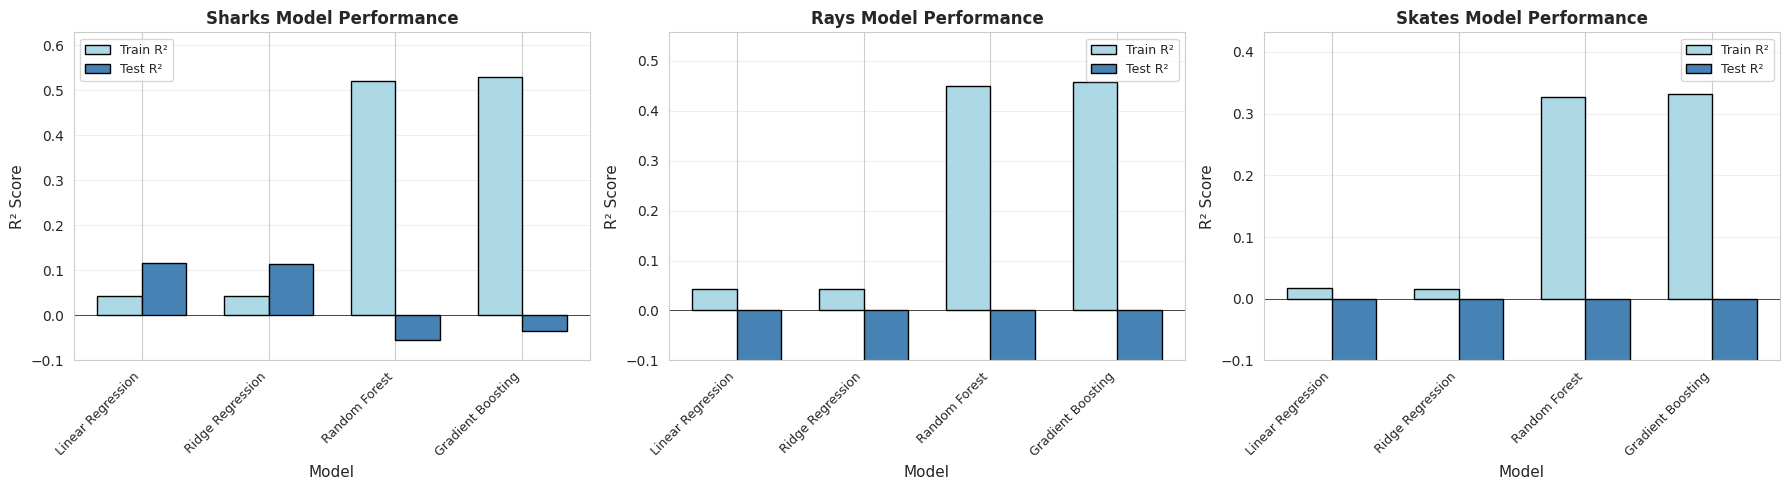

In [41]:


#Preformance Diagrams

fig1, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, species in enumerate(species_list.keys()):
    ax = axes[idx]
    species_data = comparison_df[comparison_df['Species'] == species]

    x = np.arange(len(species_data))
    width = 0.35

    bars1 = ax.bar(x - width/2, species_data['Train_R2'], width, label='Train R²', color='lightblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, species_data['Test_R2'], width, label='Test R²', color='steelblue', edgecolor='black')

    ax. set_xlabel('Model', fontsize=11)
    ax.set_ylabel('R² Score', fontsize=11)
    ax.set_title(f'{species} Model Performance', fontsize=12, fontweight='bold')
    ax. set_xticks(x)
    ax.set_xticklabels(species_data['Model'], rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_ylim([-0.1, max(species_data['Train_R2']. max(), species_data['Test_R2'].max()) + 0.1])

plt.tight_layout()

plt.show()

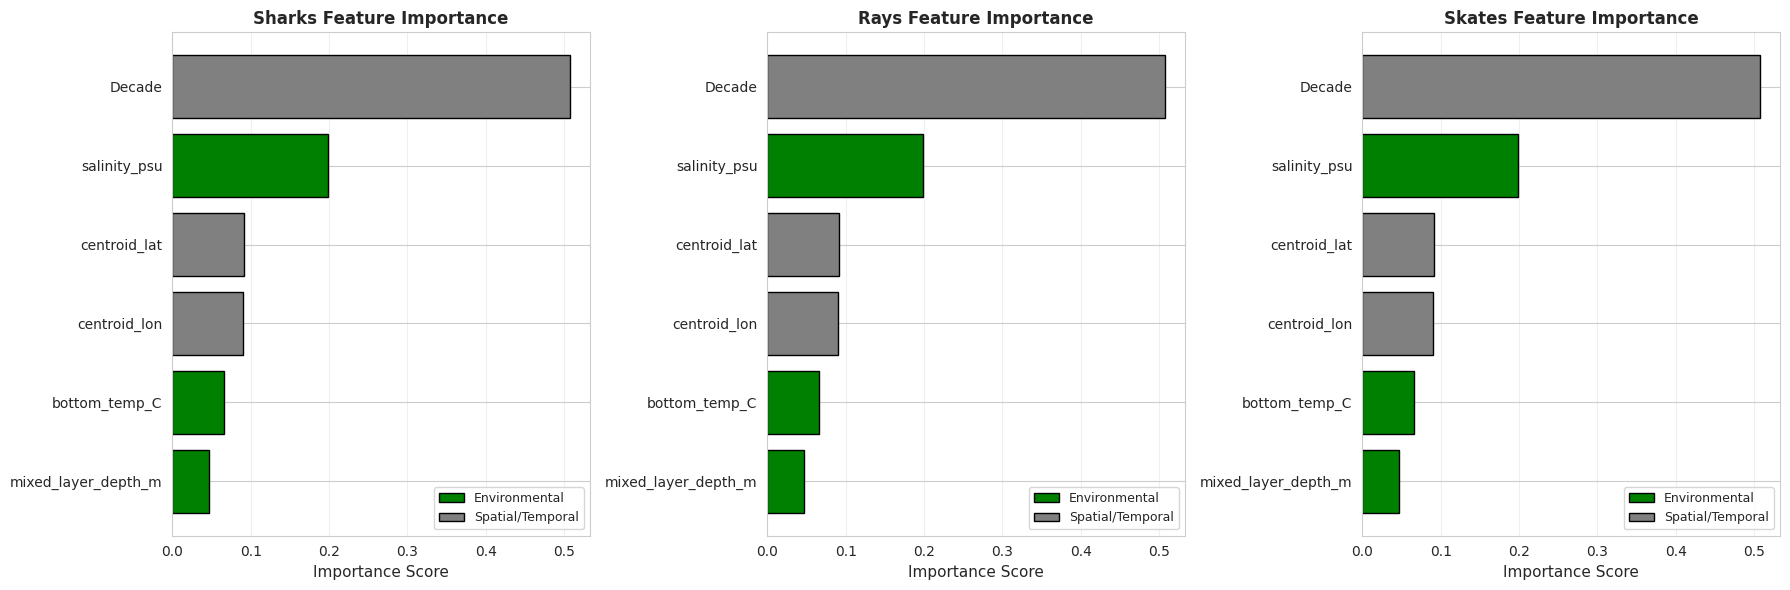

In [42]:


#Feature Importance Diagrams

fig2, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, species in enumerate(species_list.keys()):
    ax = axes[idx]
    importance_df = feature_importance_results[species]. sort_values('Importance', ascending=True)

    colors = ['green' if f in env_cols else 'gray' for f in importance_df['Feature']]

    bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black')
    ax.set_xlabel('Importance Score', fontsize=11)
    ax.set_title(f'{species} Feature Importance', fontsize=12, fontweight='bold')
    ax. grid(True, alpha=0.3, axis='x')

    legend_elements = [
        plt.Rectangle((0,0),1,1, fc='green', edgecolor='black', label='Environmental'),
        plt.Rectangle((0,0),1,1, fc='gray', edgecolor='black', label='Spatial/Temporal')
    ]
    ax.legend(handles=legend_elements, fontsize=9, loc='lower right')

plt.tight_layout()

plt.show()

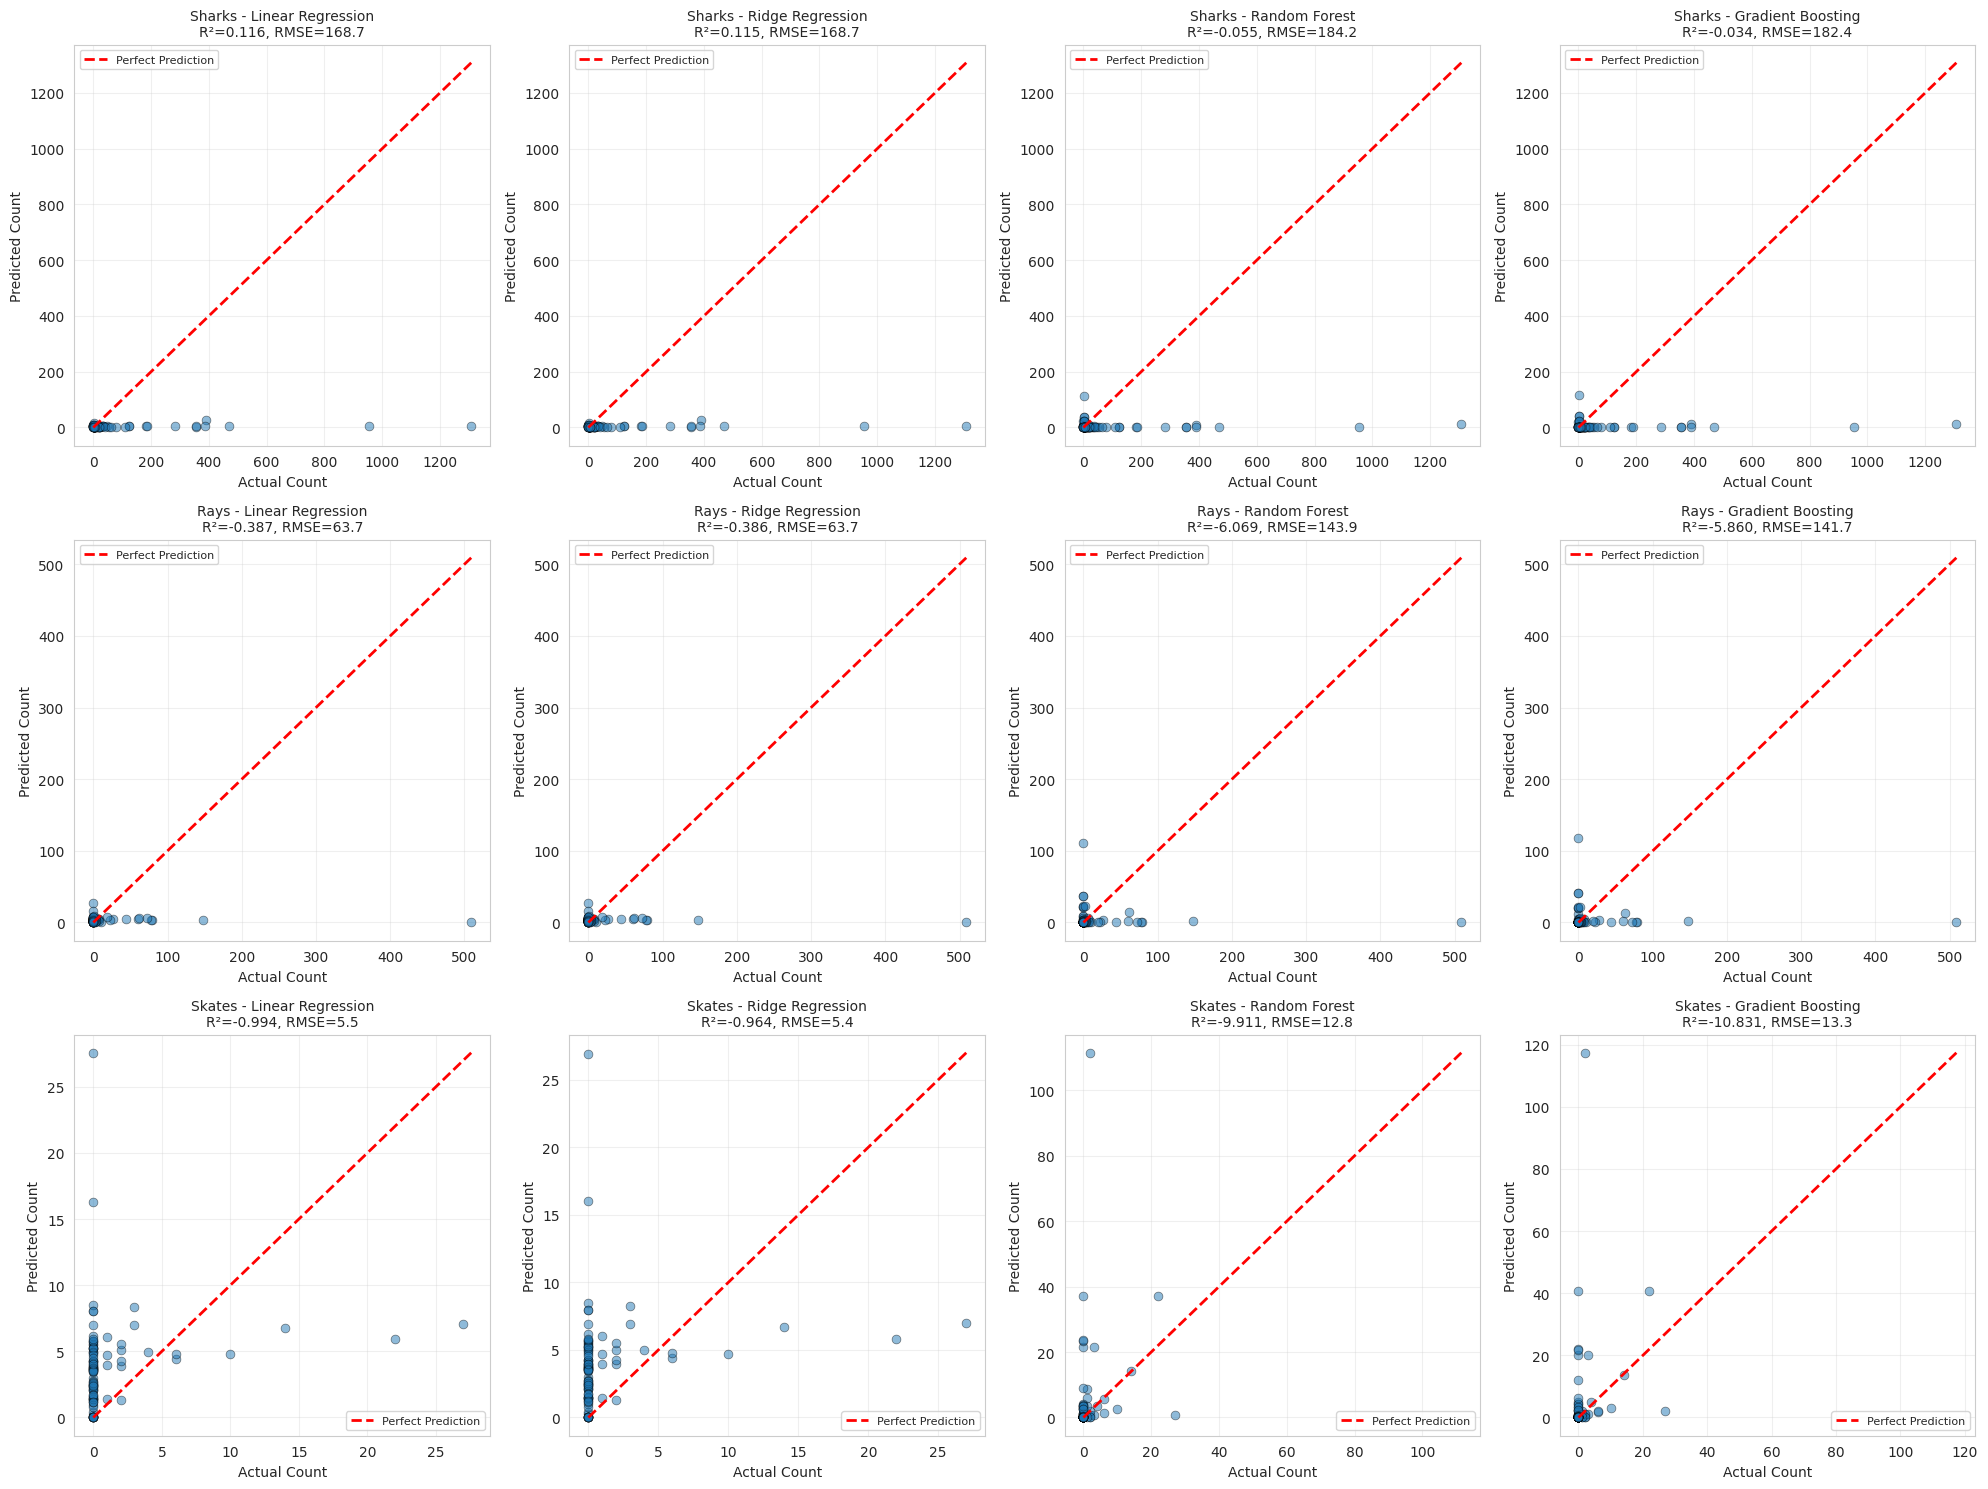

In [43]:


#Prediction Accuracy Diagrams

fig3, axes = plt.subplots(3, 4, figsize=(20, 15))

for species_idx, species in enumerate(species_list.keys()):
    y_train, y_test = species_list[species]

    for model_idx, model_name in enumerate(models_to_test.keys()):
        ax = axes[species_idx, model_idx]

        model = trained_models[species][model_name]
        y_pred = model.predict(X_test_scaled)
        y_pred = np.maximum(y_pred, 0)

        ax.scatter(y_test, y_pred, alpha=0.5, s=40, edgecolors='black', linewidth=0.5)

        max_val = max(y_test.max(), y_pred.max())
        ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

        r2 = all_results[species][model_name]['test_r2']
        rmse = all_results[species][model_name]['test_rmse']

        ax.set_xlabel('Actual Count', fontsize=10)
        ax.set_ylabel('Predicted Count', fontsize=10)
        ax.set_title(f'{species} - {model_name}\nR²={r2:.3f}, RMSE={rmse:.1f}', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.tight_layout()

plt.show()

In [44]:

#Summary

print("\nModeling Approach:")
print(f"  Models tested: {len(models_to_test)}")
print(f"  Species analyzed: {len(species_list)}")
print(f"  Total models trained: {len(models_to_test) * len(species_list)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features used: {len(selected_features)}")

print("\nBest Performing Models:")
for species, model in best_models.items():
    r2 = comparison_df[(comparison_df['Species']==species) & (comparison_df['Model']==model)]['Test_R2'].values[0]
    rmse = comparison_df[(comparison_df['Species']==species) & (comparison_df['Model']==model)]['Test_RMSE'].values[0]
    print(f"  {species}:")
    print(f"    Model: {model}")
    print(f"    Test R²: {r2:.3f}")
    print(f"    Test RMSE: {rmse:.2f}")

print("\nEnvironmental Factor Influence:")
for species in species_list.keys():
    env_importance = feature_importance_results[species][feature_importance_results[species]['Feature']. isin(env_cols)]
    top_factor = env_importance.iloc[0]['Feature']
    top_score = env_importance.iloc[0]['Importance']
    print(f"  {species}: {top_factor} (importance: {top_score:.3f})")

print("\nKey Findings:")
avg_r2 = comparison_df. groupby('Model')['Test_R2'].mean()
best_overall = avg_r2.idxmax()
print(f"  1. Best overall model type: {best_overall} (avg R²: {avg_r2[best_overall]:.3f})")

all_env_importance = pd.concat([feature_importance_results[s][feature_importance_results[s]['Feature'].isin(env_cols)] for s in species_list.keys()])
most_important_overall = all_env_importance.groupby('Feature')['Importance']. mean().idxmax()
print(f"  2. Most influential environmental factor: {most_important_overall}")

linear_avg = comparison_df[comparison_df['Model']=='Linear Regression']['Test_R2'].mean()
rf_avg = comparison_df[comparison_df['Model']=='Random Forest']['Test_R2'].mean()
if rf_avg > linear_avg + 0.1:
    print(f"  3. Non-linear relationships detected (RF R²={rf_avg:.3f} vs Linear R²={linear_avg:. 3f})")
else:
    print(f"  3.  Relationships are approximately linear")



Modeling Approach:
  Models tested: 4
  Species analyzed: 3
  Total models trained: 12
  Training samples: 402
  Test samples: 101
  Features used: 6

Best Performing Models:
  Sharks:
    Model: Linear Regression
    Test R²: 0.116
    Test RMSE: 168.67
  Rays:
    Model: Ridge Regression
    Test R²: -0.386
    Test RMSE: 63.71
  Skates:
    Model: Ridge Regression
    Test R²: -0.964
    Test RMSE: 5.44

Environmental Factor Influence:
  Sharks: salinity_psu (importance: 0.198)
  Rays: salinity_psu (importance: 0.198)
  Skates: salinity_psu (importance: 0.198)

Key Findings:
  1. Best overall model type: Ridge Regression (avg R²: -0.412)
  2. Most influential environmental factor: salinity_psu
  3.  Relationships are approximately linear
